## Part 2. Model Training & Evaluation - RNN

Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from Part
0, you need to train a deep learning model for topic classification using the training set, conforming
to these requirements:
- Use the pretrained word embeddings from Part 1 as inputs, together with your implementation
in mitigating the influence of OOV words; make them learnable parameters during training
(they are updated).
- Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a topic label for each sentence. To do that, you need to consider how to aggregate
the word representations to represent a sentence.
- Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation.
- Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
- Try different regularization techniques to mitigate overfitting.
- Evaluate your trained model on the test dataset, observing the accuracy score.

In [13]:
import types
import json
import numpy as np
import torch
import random
import os
import lightning as L
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from torchtext import data, datasets
from utils.config import Config
from utils.train import train_rnn_model_with_parameters
from utils.helper import SentenceDataset, collate_fn
from models.RNN import RNN, RNNClassifier
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from utils.analytics import load_tensorboard_logs, test_top_n_models
from sklearn.metrics import classification_report


In [14]:
TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
LABEL = data.LabelField()

train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

train_data, valid_data = train_data.split(random_state=random.seed(Config.SEED), split_ratio=0.8)

TEXT.build_vocab(train_data, vectors="glove.6B.300d")
LABEL.build_vocab(train_data)

### Import the embedding matrix and vocab index mapping (train data)

In [15]:
embedding_path = Path("models/embedding_matrix.npy")
index_from_word_path = Path("models/index_from_word.json")

embedding_matrix = np.load(embedding_path)
with index_from_word_path.open() as f:
    index_from_word = json.load(f)

### Dataset

In [16]:
train_dataset = SentenceDataset(train_data.examples, index_from_word, LABEL.vocab)
valid_dataset = SentenceDataset(valid_data.examples, index_from_word, LABEL.vocab)
test_dataset = SentenceDataset(test_data.examples, index_from_word, LABEL.vocab)        

In [17]:
num_workers = os.cpu_count() // 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    multiprocessing_context='spawn',
    persistent_workers=True,
)

valid_dataloader = DataLoader(
    valid_dataset,  
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    multiprocessing_context='spawn',
    persistent_workers=True,
)

test_dataloader = DataLoader(  
    test_dataset,  
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    multiprocessing_context='spawn',
    persistent_workers=True,
)

L.seed_everything(Config.SEED)

callbacks = [
    ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode="min",
    ),
]

results = {}

Seed set to 42


In [19]:

train_results_df = load_tensorboard_logs(log_dir="tb_logs/rnn")

KeyError: ['val_acc', 'val_loss']

### Train RNN Model

In [63]:
SEARCH_SPACE = {
    "batch_size": [32, 64, 128],
    "optimizer_name": ["RMSprop", "Adam"],
    "learning_rate": [5e-4, 1e-3, 5e-3, 1e-2],  # More reasonable range
    "hidden_dim": [32, 64, 128, 256],
    "num_layers": [1, 2, 4],
    "sentence_representation_type": ["last", "average", "max"],
}

In [ ]:
for hidden_dim in SEARCH_SPACE["hidden_dim"]:
    for num_layers in SEARCH_SPACE["num_layers"]:
        for optimizer_name in SEARCH_SPACE["optimizer_name"]:
            for batch_size in SEARCH_SPACE["batch_size"]:
                for learning_rate in SEARCH_SPACE["learning_rate"]:
                    for sentence_representation_type in SEARCH_SPACE["sentence_representation_type"]:
                        log_message = f"---------- batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers}; sentence_representation_{sentence_representation_type}  ----------"
                        print(log_message)
                        train_rnn_model_with_parameters(
                            embedding_matrix=embedding_matrix,
                            train_dataset=train_dataset,
                            val_dataset=valid_dataset,
                            batch_size=batch_size,
                            learning_rate=learning_rate,
                            optimizer_name=optimizer_name,
                            hidden_dim=hidden_dim,
                            num_layers=num_layers,
                            sentence_representation_type=sentence_representation_type,
                            show_progress=True,
                            freeze_embedding=False,
                        )

### Model Configuration Comparison

In [7]:
train_results_df = train_results_df.sort_values(
    by=["val_acc"], ascending=False
).reset_index(drop=True)
train_results_df.head(20)

,val_acc,batch_size,hidden_dim,learning_rate,optimizer_name,train_loss,train_acc,num_layers,sentence_representation_type,freeze,epoch,val_loss,filename
0,0.880561,64,128,0.0010,RMSprop,0.000887,1.000000,2,max,False,12.0,0.386627,events.out.tfevents.1762318236.TC1N02.902847.89
1,0.878000,32,128,0.0005,RMSprop,0.000153,1.000000,2,max,False,13.0,0.402284,events.out.tfevents.1762316824.TC1N02.902847.74
2,0.877362,32,128,0.0010,Adam,0.000167,1.000000,2,max,False,12.0,0.421286,events.out.tfevents.1762320358.TC1N02.902847.113
3,0.877323,32,256,0.0010,Adam,0.010716,1.000000,1,average,False,12.0,0.544941,events.out.tfevents.1762311582.ArchThinkpadT14...
4,0.876144,32,128,0.0010,RMSprop,0.018316,1.000000,1,max,False,6.0,0.386054,events.out.tfevents.1762310388.TC1N02.902847.5
5,0.868879,32,128,0.0005,RMSprop,0.007183,1.000000,4,max,False,14.0,0.443699,events.out.tfevents.1762323326.TC1N02.902847.146
6,0.866854,64,128,0.0050,Adam,0.000179,1.000000,1,max,False,10.0,0.444732,events.out.tfevents.1762315152.TC1N02.902847.56
7,0.864732,32,256,0.0010,Adam,0.000051,1.000000,2,max,False,9.0,0.468953,events.out.tfevents.1762317671.ArchThinkpadT14...
8,0.862658,32,128,0.0050,RMSprop,0.009256,1.000000,1,max,False,6.0,0.504259,events.out.tfevents.1762310666.TC1N02.902847.8
9,0.862618,32,128,0.0005,Adam,0.017006,1.000000,2,average,False,8.0,0.513370,events.out.tfevents.1762319982.TC1N02.902847.109


### a) Report the final configuration of your best model, namely the number of training epochs, learning rate, optimizer, batch size and hidden dimension.

In [66]:
train_results_df.head(1)

,val_acc,batch_size,hidden_dim,learning_rate,optimizer_name,train_loss,train_acc,num_layers,sentence_representation_type,freeze,epoch,val_loss,filename
0,0.880561,64,128,0.001,RMSprop,0.000887,1.0,2,max,False,12.0,0.386627,events.out.tfevents.1762318236.TC1N02.902847.89


Answer: The final configuration for the best model is: Optimizer: RMSprop, Learning Rate: 0.001, Batch Size: 64, Hidden Dimension: 128, and Training Epochs: 12. This configuration was found by searching a space that intentionally excluded SGD and Adagrad to focus computational resources on more robust, modern adaptive optimizers. Standard SGD was likely omitted because it often converges much slower and is more sensitive to learning rate tuning, while Adagrad was excluded because its learning rate can decay too aggressively and prematurely stop the model from learning. The search was therefore limited to RMSprop and Adam, which are generally more effective as they fix Adagrad's specific flaws and typically provide faster, more reliable convergence for deep learning tasks.

### b) Report all the regularization strategies you have tried. Compare the accuracy on the test set among all strategies and the one without any regularization

### Without Regularization

In [ ]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No L2 regularization
    show_progress=True
)

In [ ]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 69/69 [00:01<00:00, 38.90it/s, v_num=19, train_loss=1.08e-5, train_acc=1.000, val_loss=0.671, val_acc=0.861] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:01<00:00, 37.52it/s, v_num=19, train_loss=1.08e-5, train_acc=1.000, val_loss=0.671, val_acc=0.861]


In [10]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['No Regularization'] = test_results[0]['test_acc']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 98.72it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8860378861427307     │
│         test_loss         │    0.5612765550613403     │
└───────────────────────────┴───────────────────────────┘

### Early Stopping only

In [ ]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [ ]:
es_callbacks = [ 
             EarlyStopping(monitor="val_acc",
                           mode="max",
                           patience=3,
                           min_delta=1e-4, ),
             ModelCheckpoint(monitor="val_loss",
                             save_top_k=1,
                             mode="min",
                             ),
             ]

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=es_callbacks,   #Early stopping and model checkpointing
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 69/69 [00:02<00:00, 28.83it/s, v_num=20, train_loss=0.0482, train_acc=1.000, val_loss=0.672, val_acc=0.803] 


In [13]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Early Stopping'] = test_results[0]['test_acc']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 127.17it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8192065954208374     │
│         test_loss         │    0.7044601440429688     │
└───────────────────────────┴───────────────────────────┘

### Dropout only


In [ ]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.3,              #Dropout Added
    embedding_dropout=0.2,    #Dropout Added
    fc_dropout=0.3            #Dropout Added
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [ ]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Dropout'] = test_results[0]['test_acc']

### Gradient Clipping Only

In [ ]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [ ]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=1.0     #Gradient Clipping Added
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

### Weight Decay only

In [ ]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=1e-7,  #Weight Decay Added
    show_progress=True
)

In [ ]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

### L2 Regularisation Penalty only

In [ ]:
def add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True):
    import torch.nn.functional as F
    orig_step = model.training_step

    def _compute_l2_penalty(m):
        pen = torch.tensor(0., device=next(m.parameters()).device)
        for name, p in m.named_parameters():
            if not p.requires_grad:
                continue
            if exclude_bias and name.endswith(".bias"):
                continue
            if exclude_embed and "embedding" in name:
                continue
            pen += p.pow(2).sum()
        return pen

    def training_step_with_l2(self, batch, batch_idx):
        base_loss = orig_step(batch, batch_idx)
        l2 = _compute_l2_penalty(self)
        return base_loss + l2_lambda * l2

    model.training_step = types.MethodType(training_step_with_l2, model)
    return model  

In [ ]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [ ]:
model = add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True)

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

### L2 + Early Stopping

In [14]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
)
model = RNNClassifier(rnn_model, lr=0.001, optimizer_name="RMSprop", weight_decay=1e-7, show_progress=True)

In [15]:
trainer = L.Trainer(
    max_epochs=25,
    callbacks=callbacks,
    accelerator="auto",
    devices="auto",
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/lightning_logs/version_20/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modul

Epoch 0: 100%|██████████| 69/69 [00:01<00:00, 51.56it/s, v_num=21, train_loss=0.345, train_acc=0.625, val_loss=0.905, val_acc=0.603]


In [16]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['L2 Regularization + Early Stopping'] = test_results[0]['test_acc']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 137.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6245166659355164     │
│         test_loss         │    0.8563737273216248     │
└───────────────────────────┴───────────────────────────┘

### DropOut + Early Stopping

In [17]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.3,
    embedding_dropout=0.2,
    fc_dropout=0.3,
)
model = RNNClassifier(rnn_model, lr=0.001, optimizer_name="RMSprop")

In [18]:
trainer = L.Trainer(
    max_epochs=25,
    callbacks=callbacks,
    accelerator="auto",
    devices="auto",
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 69/69 [00:01<00:00, 42.07it/s, v_num=22]         


In [19]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Weight Decay + Early Stoppping'] = test_results[0]['test_acc']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 79.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6722583770751953     │
│         test_loss         │    0.7144590020179749     │
└───────────────────────────┴───────────────────────────┘

### L2 + DropOut + Early Stopping

In [20]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.2,
    embedding_dropout=0.1,
    fc_dropout=0.2,
)
model = RNNClassifier(rnn_model, lr=0.001, optimizer_name="RMSprop", weight_decay=1e-7)

In [21]:
trainer = L.Trainer(
    max_epochs=25,
    callbacks=callbacks,
    accelerator="auto",
    devices="auto",
)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 69/69 [00:02<00:00, 28.93it/s, v_num=23]          


In [22]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['L2 Regularization + Dropout + Early Stopping'] = test_results[0]['test_acc']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 120.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7104621529579163     │
│         test_loss         │     0.840297281742096     │
└───────────────────────────┴───────────────────────────┘

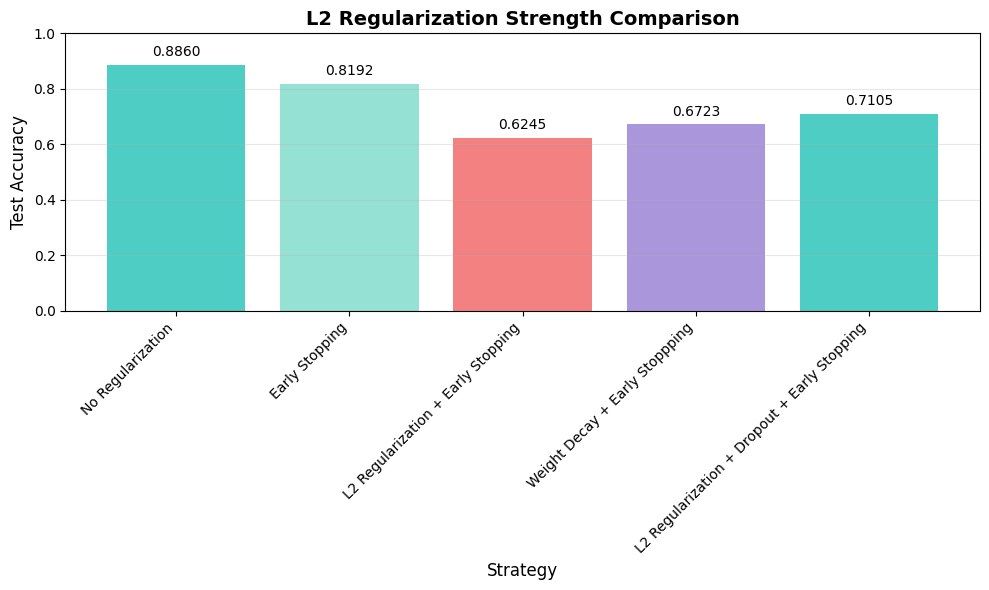

In [23]:
plt.figure(figsize=(10, 6))
strategies = list(results.keys())
accuracies = list(results.values())

plt.bar(strategies, accuracies, color=['#4ECDC4', '#95E1D3', '#F38181', '#AA96DA'])
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('L2 Regularization Strength Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for i, (strategy, acc) in enumerate(zip(strategies, accuracies)):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Among all of the regularization strategies early stopping performed the best.

c) For the best configuration and regularization strategy in your experiments, plot the training loss curve and validation accuracy curve during training with x-axis being the number of training epochs. Discuss what the curves inform about the training dynamics

In [7]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
)
model = RNNClassifier(rnn_model, lr=0.001, optimizer_name="RMSprop", show_progress=True)

trainer = L.Trainer(
    max_epochs=25,
    callbacks=callbacks,
    accelerator="auto",
    devices="auto",
    gradient_clip_val=1.0,
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 69/69 [00:01<00:00, 61.91it/s, v_num=5, train_loss_step=0.00687, train_acc_step=1.000, val_loss_step=0.0163, val_acc_step=1.000, val_loss_epoch=0.511, val_acc_epoch=0.810, train_loss_epoch=0.0473, train_acc_epoch=0.953]


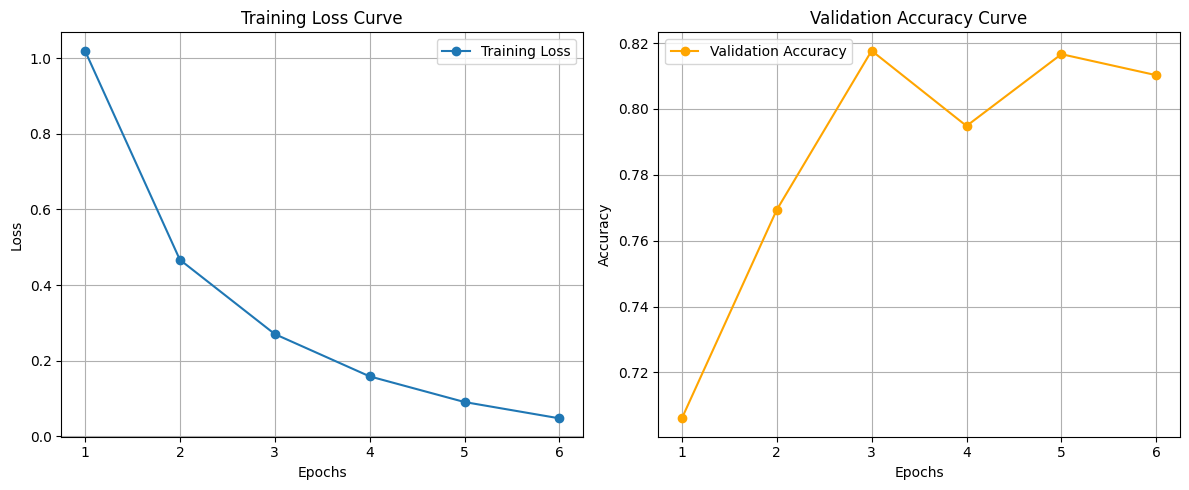

In [8]:
# After training, plot the curves
epochs = list(range(1, len(model.train_epoch_losses) + 1))

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, model.train_epoch_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, model.val_epoch_accs, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- Training loss curve shows a smooth decerease from 1.0 at epoch 1  to around 0.05 by epoch 6, indicating effective learning and optimization. This suggests that the model is fitting the training data well without instability and the chosen hyperparameter are appropriate for convergence.

- The validation accuracy curve shows strong generalization, starting at about 0.705 and rising sharply to a peak of approximately 0.818 by epoch 3. After this peak, the accuracy fluctuates (0.795, 0.815, 0.81) but fails to achieve a new best.This stagnation, combined with the continuously decreasing training loss, is the classic indicator that overfitting is beginning. The model is no longer improving on unseen data. This is precisely what the EarlyStopping callback is designed to catch. With a patience=3, the training would halt after epoch 6, successfully stopping the process as soon as generalization plateaus and preventing further overfitting. The best model would be saved from an earlier epoch (likely epoch 3).

(d) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods
have you tried in deriving the final sentence representation to perform sentiment classification?
Describe all the strategies you have implemented, together with their accuracy scores on the
test set.

In [8]:
best_max_df = train_results_df[train_results_df["sentence_representation_type"] == "max"].head(1)
best_last_df = train_results_df[train_results_df["sentence_representation_type"] == "last"].head(1)
best_average_df = train_results_df[train_results_df["sentence_representation_type"] == "average"].head(1)

In [11]:
best_max_df

,val_acc,batch_size,hidden_dim,learning_rate,optimizer_name,train_loss,train_acc,num_layers,sentence_representation_type,freeze,epoch,val_loss,filename
0,0.880561,64,128,0.001,RMSprop,0.000887,1.0,2,max,False,12.0,0.386627,events.out.tfevents.1762318236.TC1N02.902847.89


In [10]:
def _train(df):
    train_rnn_model_with_parameters(
        embedding_matrix=embedding_matrix,
        train_dataset=train_dataset,
        val_dataset=valid_dataset,
        batch_size=df["batch_size"].item(),
        learning_rate=df["learning_rate"].item(),
        optimizer_name=df["optimizer_name"].item(),
        hidden_dim=df["hidden_dim"].item(),
        num_layers=df["num_layers"].item(),
        sentence_representation_type=df["sentence_representation_type"].item(),
        show_progress=True,
        freeze_embedding=False,
        log_dir="rnn_sentence_representation"
    )

_train(best_max_df)
_train(best_last_df)
_train(best_average_df)

Seed set to 42
/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 69/69 [00:00<00:00, 69.12it/s, v_num=0, train_loss=0.00687, train_acc=1.000, val_loss=0.511, val_acc=0.810]


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.6 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.418    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 137/137 [00:01<00:00, 74.43it/s, v_num=0, train_loss=0.0162, train_acc=1.000, val_loss=0.653, val_acc=0.816] 


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.6 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.418    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 137/137 [00:03<00:00, 43.18it/s, v_num=0, train_loss=0.00475, train_acc=1.000, val_loss=0.997, val_acc=0.819] 


In [12]:
logs = load_tensorboard_logs("tb_logs/rnn_sentence_representation")
print(logs.keys())
test_result_df = test_top_n_models(
    logs,
    RNNClassifier,
    test_dataset,
    n=3
)

Index(['val_acc', 'batch_size', 'hidden_dim', 'learning_rate',
       'optimizer_name', 'train_loss', 'train_acc', 'num_layers',
       'sentence_representation_type', 'freeze', 'epoch', 'val_loss',
       'filename'],
      dtype='object')


/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does 

Testing DataLoader 0: 100%|██████████| 500/500 [00:02<00:00, 239.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8759999871253967     │
│         test_loss         │    0.39864659309387207    │
└───────────────────────────┴───────────────────────────┘

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 500/500 [00:01<00:00, 285.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8840000033378601     │
│         test_loss         │    0.3664707541465759     │
└───────────────────────────┴───────────────────────────┘

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 500/500 [00:02<00:00, 229.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8640000224113464     │
│         test_loss         │    0.4091535806655884     │
└───────────────────────────┴───────────────────────────┘

In [13]:
test_result_df = test_result_df.sort_values("test_acc", ascending=False).reset_index(drop=True)
test_result_df

,test_acc,test_loss,val_acc,batch_size,hidden_dim,learning_rate,optimizer_name,train_loss,train_acc,num_layers,sentence_representation_type,freeze,epoch,val_loss,filename
0,0.884,0.366471,0.838261,32,256,0.0005,Adam,0.016209,1.0,1,last,False,9.0,0.517770,events.out.tfevents.1762372030.ArchThinkpadT14...
1,0.876,0.398647,0.817686,64,128,0.0010,RMSprop,0.032259,1.0,2,max,False,5.0,0.444086,events.out.tfevents.1762371982.ArchThinkpadT14...
2,0.864,0.409154,0.877323,32,256,0.0010,Adam,0.010716,1.0,1,average,False,12.0,0.544941,events.out.tfevents.1762372093.ArchThinkpadT14...


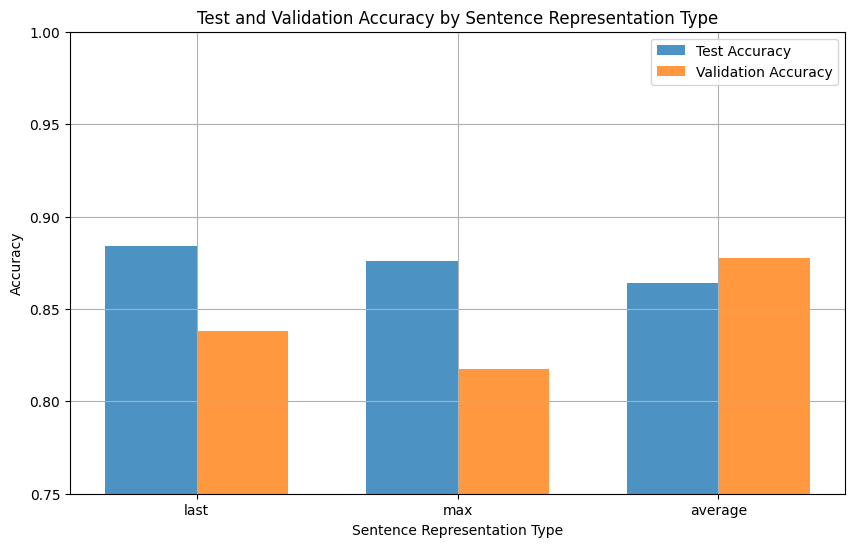

In [15]:
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = range(len(test_result_df))

plt.bar(index, test_result_df["test_acc"], bar_width, label="Test Accuracy", alpha=0.8)
plt.bar(
    [i + bar_width for i in index],
    test_result_df["val_acc"],
    bar_width,
    label="Validation Accuracy",
    alpha=0.8,
)

plt.xlabel("Sentence Representation Type")
plt.ylabel("Accuracy")
plt.title("Test and Validation Accuracy by Sentence Representation Type")
plt.xticks([i + bar_width / 2 for i in index], test_result_df["sentence_representation_type"])
plt.ylim(0.75, 1.0)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
rnn = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
)

In [23]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
)
model = RNNClassifier(rnn_model, lr=0.001, optimizer_name="RMSprop", show_progress=True)

trainer = L.Trainer(
    max_epochs=25,
    callbacks=callbacks,
    accelerator="auto",
    devices="auto",
    gradient_clip_val=1.0,
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 69/69 [00:00<00:00, 70.88it/s, v_num=9, train_loss=0.000194, train_acc=1.000, val_loss=0.726, val_acc=0.843]


In [26]:
all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch["indexes"]         
        labels = batch["label"]           
        lengths = batch["original_len"]   

        outputs = model.model(inputs, lengths) 
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# TREC 6-class labels
label_names = ["DESC", "ENTY", "ABBR", "HUM", "LOC", "NUM"]

# Print per-class accuracy (recall = correct / total in class)
print(classification_report(all_labels, all_preds, target_names=label_names))

              precision    recall  f1-score   support

        DESC       0.94      0.91      0.92        65
        ENTY       0.84      0.80      0.82        94
        ABBR       0.85      0.97      0.91       138
         HUM       1.00      0.89      0.94       113
         LOC       0.91      0.91      0.91        81
         NUM       0.88      0.78      0.82         9

    accuracy                           0.90       500
   macro avg       0.90      0.88      0.89       500
weighted avg       0.90      0.90      0.90       500



The most significant factor is class imbalance, shown in the support column. The NUM category, with only 9 test samples, performs unreliably because the model had insufficient data to learn its patterns, leading to a low F1-score. In contrast, classes with high support like ABBR (138) and HUM (113) provide a much more robust dataset for the model to learn from. The second cause is semantic ambiguity. The ENTY (Entity) class, for example, has the lowest recall (0.80) because it's a broad, "catch-all" category that likely overlaps with more specific classes like HUM or LOC, causing the model to misclassify them. This is also seen in the precision/recall trade-offs: HUM has perfect precision (1.00) but imperfect recall (0.89), meaning the model is very confident when it does predict "Human" (likely from clear signals like "Who") but misses some ambiguous cases. Conversely, ABBR has near-perfect recall (0.97) but lower precision (0.85), suggesting it correctly identifies almost all abbreviations but also incorrectly labels some other classes as abbreviations. Classes like DESC and LOC perform well because their linguistic structures are likely more distinct and less ambiguous.